<a href="https://colab.research.google.com/github/omavashia2005/DigitClassifier/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import torch
import torchvision
from torchvision import datasets
from torch import nn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Get dataset

In [2]:
train_data = datasets.MNIST(
    root="data",
    train = True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train = False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]


In [3]:
y = train_data.classes
y

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# Visualize Data

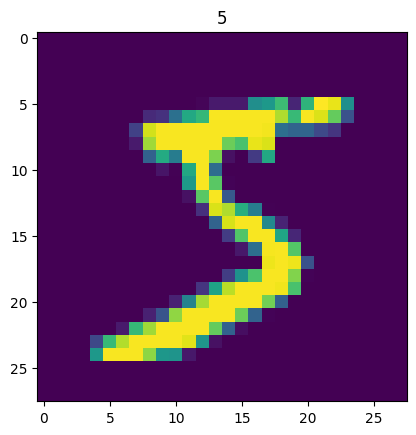

In [4]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label);

# DataLoader

In [5]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))

In [7]:
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Baseline

`nn.Flatten()` essentially returns a tensor of dimension `[color_channels, height * width]`

In [8]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

## Model 0

In [9]:
class MNISTModelV0(nn.Module):
  def __init__(self, input_shape : int, hidden_units: int, output_shape: int):
    super().__init__()

    self.single_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )
  def forward(self, x):
    return self.single_layer(x)

## Instantiate

In [10]:
model_0 = MNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(y))
model_0.to('cpu')

MNISTModelV0(
  (single_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Loss and Cost

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Time to test and train

In [12]:
from tqdm import tqdm
torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
  train_loss = 0

  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # generate prediction
    y_pred = model_0(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # optmizer zero grad
    optimizer.zero_grad()

    # Backpropagate
    loss.backward()

    # Optimizer step
    optimizer.step()

    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  # Testing

  test_loss, test_acc = 0, 0

  model_0.eval()
  with torch.no_grad():
    for X, y in test_dataloader:
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:08<00:16,  8.20s/it]


Train loss: 0.40366 | Test loss: 0.29508, Test acc: 91.56%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:16<00:07,  7.97s/it]


Train loss: 0.30810 | Test loss: 0.29659, Test acc: 91.64%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


Train loss: 0.29583 | Test loss: 0.29090, Test acc: 91.97%



## Making Predictions

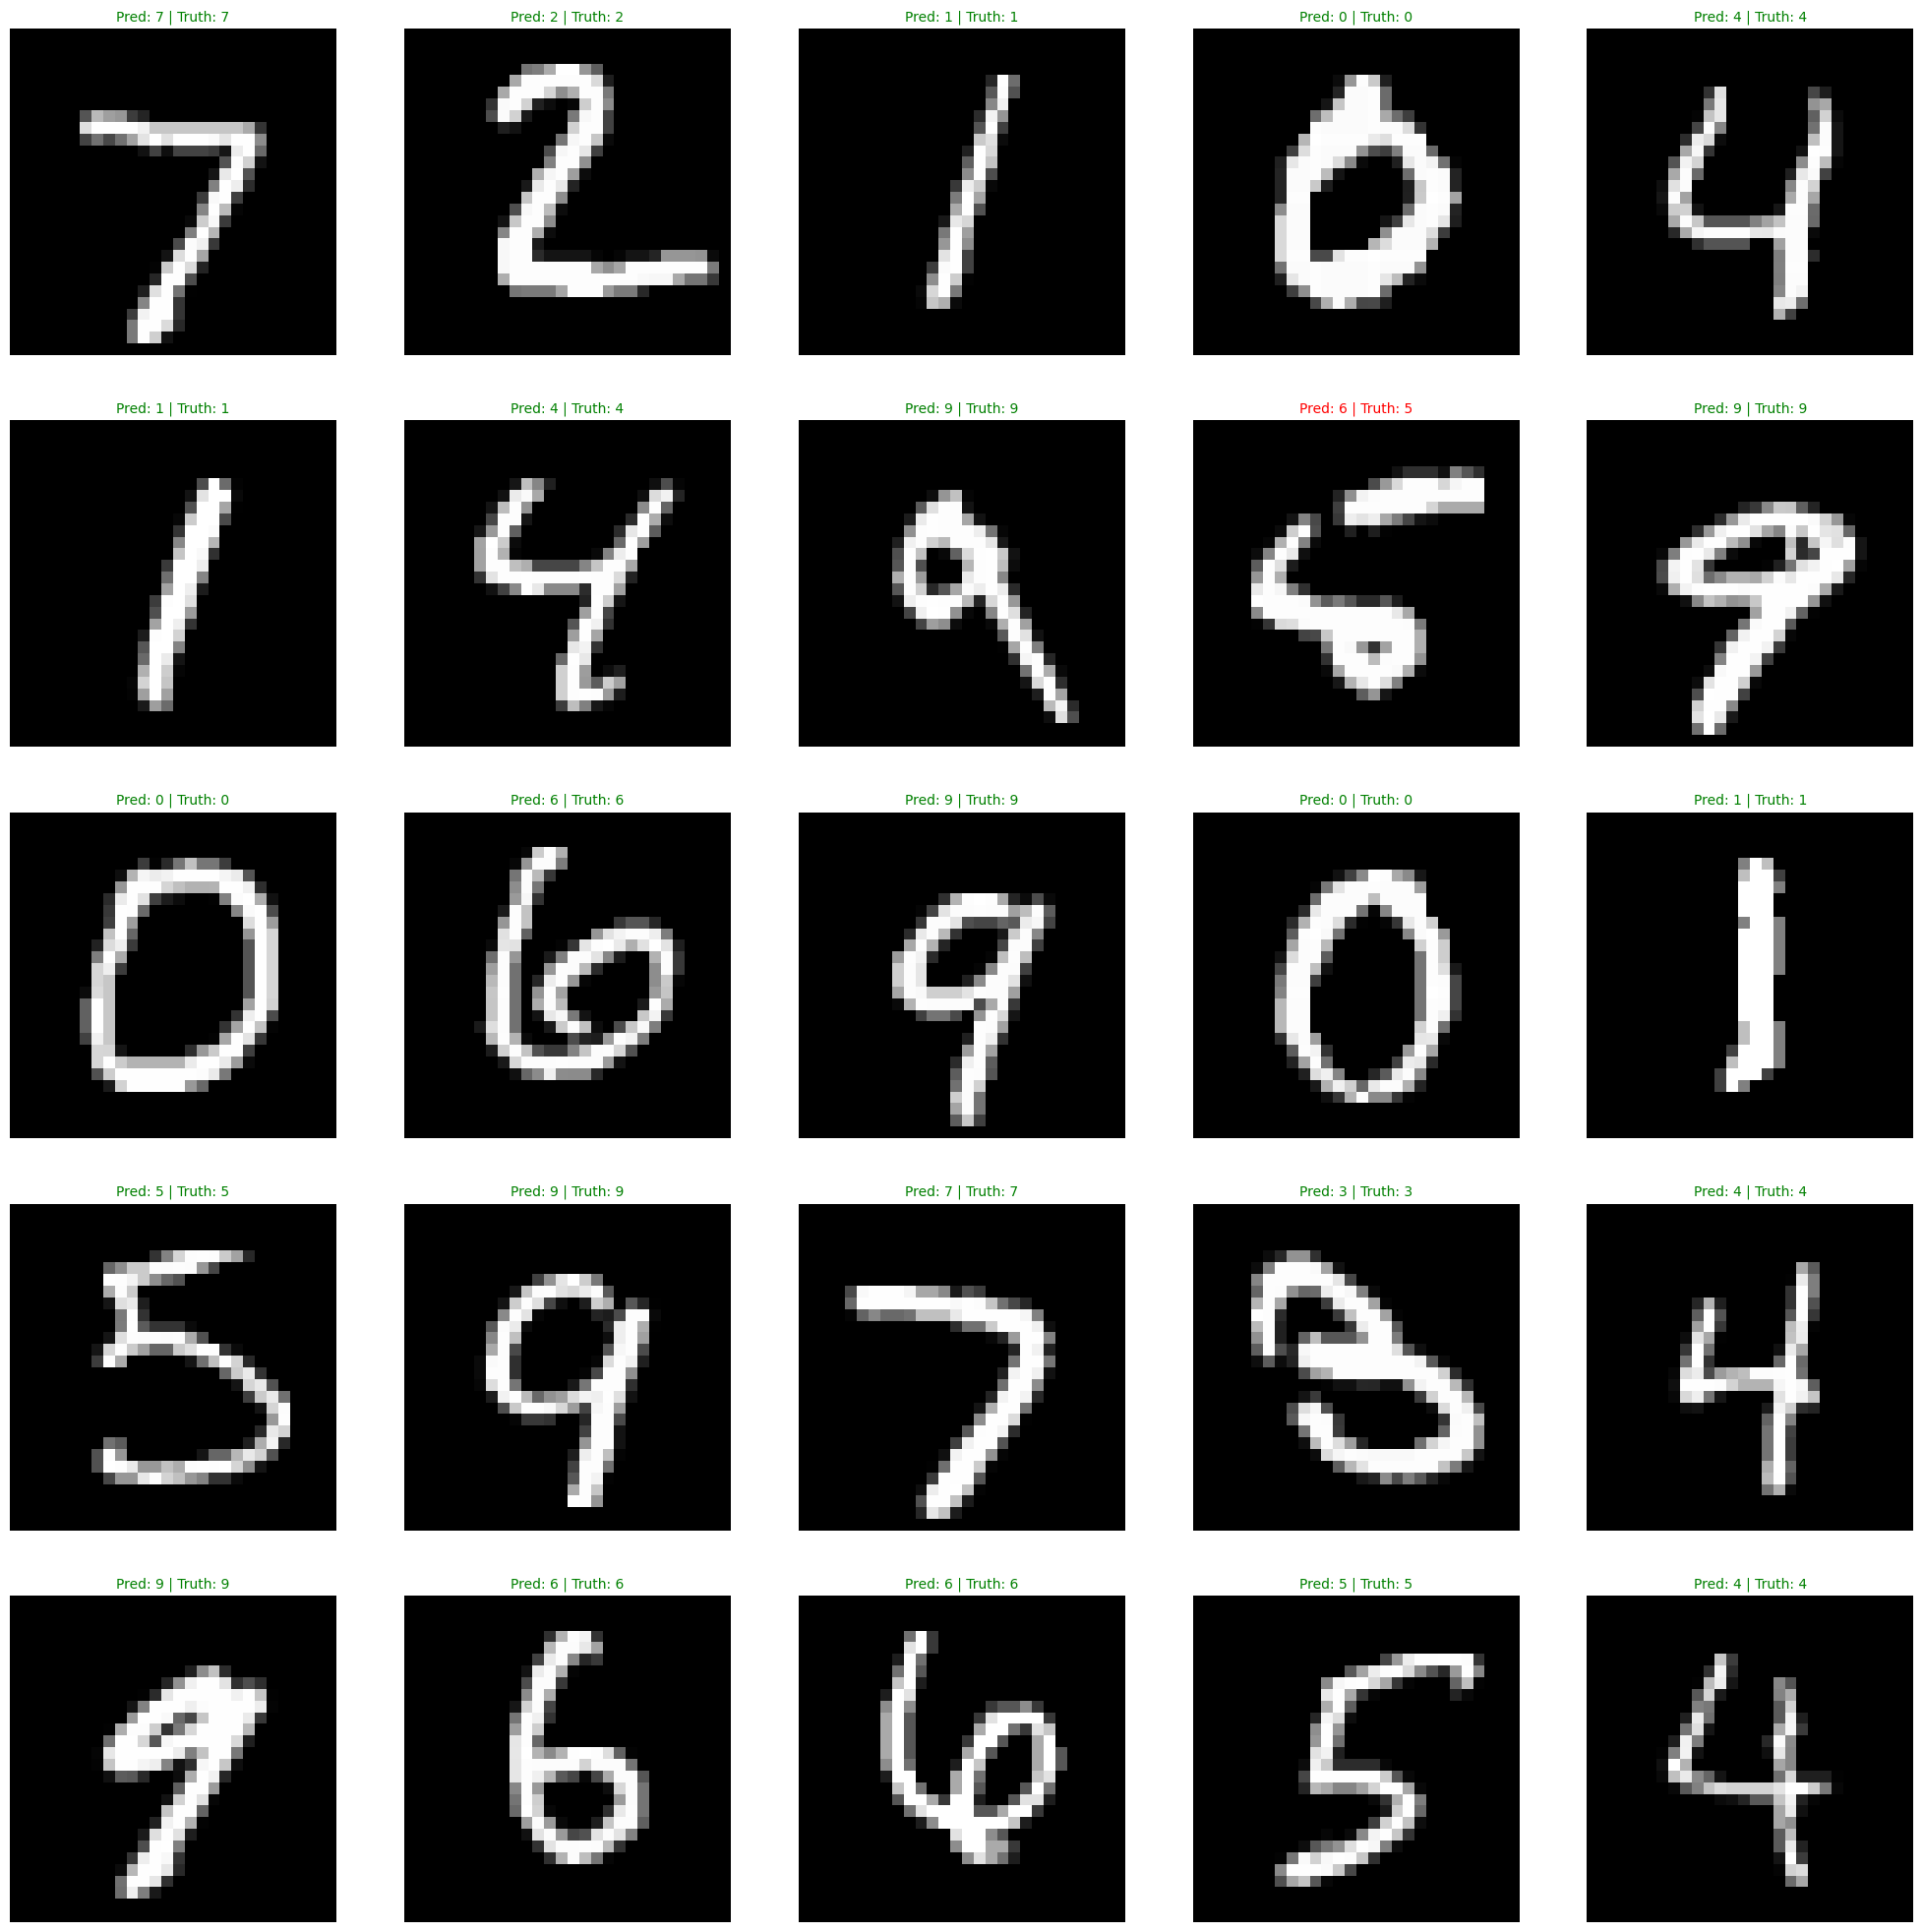

In [13]:
plt.figure(figsize=(25,25))
nrows = 5
ncols = 5
for i in range(nrows * ncols):
  image, label = test_data[i]
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(image.squeeze(), cmap='gray')
  model_0.eval()
  with torch.no_grad():
    pred_label = model_0(image)
    pred_label = pred_label.argmax(dim=1)
    pred_label = pred_label.squeeze()
  title_text = f"Pred: {pred_label} | Truth: {label}"

  if pred_label == label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);


# CNN

In [14]:
device = 'cuda'

In [15]:
class MNISTModelV1(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels = input_shape,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
          in_channels = hidden_units,
          out_channels = hidden_units,
          kernel_size = 3,
          stride = 1,
          padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2 )
        )

    self.conv2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
          in_channels = hidden_units,
          out_channels = hidden_units,
          kernel_size = 3,
          stride = 1,
          padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2 )
        )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
    )

  def forward(self, x):

    x = self.conv1(x)

    x = self.conv2(x)

    x = self.classifier(x)

    return x

model_1 = MNISTModelV1(
    input_shape = 1,
    hidden_units = 10,
    output_shape =len(y)).to(device)
model_1


MNISTModelV1(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=16, bias=True)
  )
)

## Loss and Optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_1.parameters(), lr = 0.1)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Train and test

In [17]:
from tqdm import tqdm
epochs = 3
model_1.to(device)
for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    model_1.train()

    y_pred = model_1(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_1.eval()
  with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model_1(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

 33%|███▎      | 1/3 [00:13<00:26, 13.47s/it]


Train loss: 0.26715 | Test loss: 0.07227, Test acc: 97.60%



 67%|██████▋   | 2/3 [00:25<00:12, 12.36s/it]


Train loss: 0.07353 | Test loss: 0.05294, Test acc: 98.27%



100%|██████████| 3/3 [00:36<00:00, 12.13s/it]


Train loss: 0.05852 | Test loss: 0.05394, Test acc: 98.36%



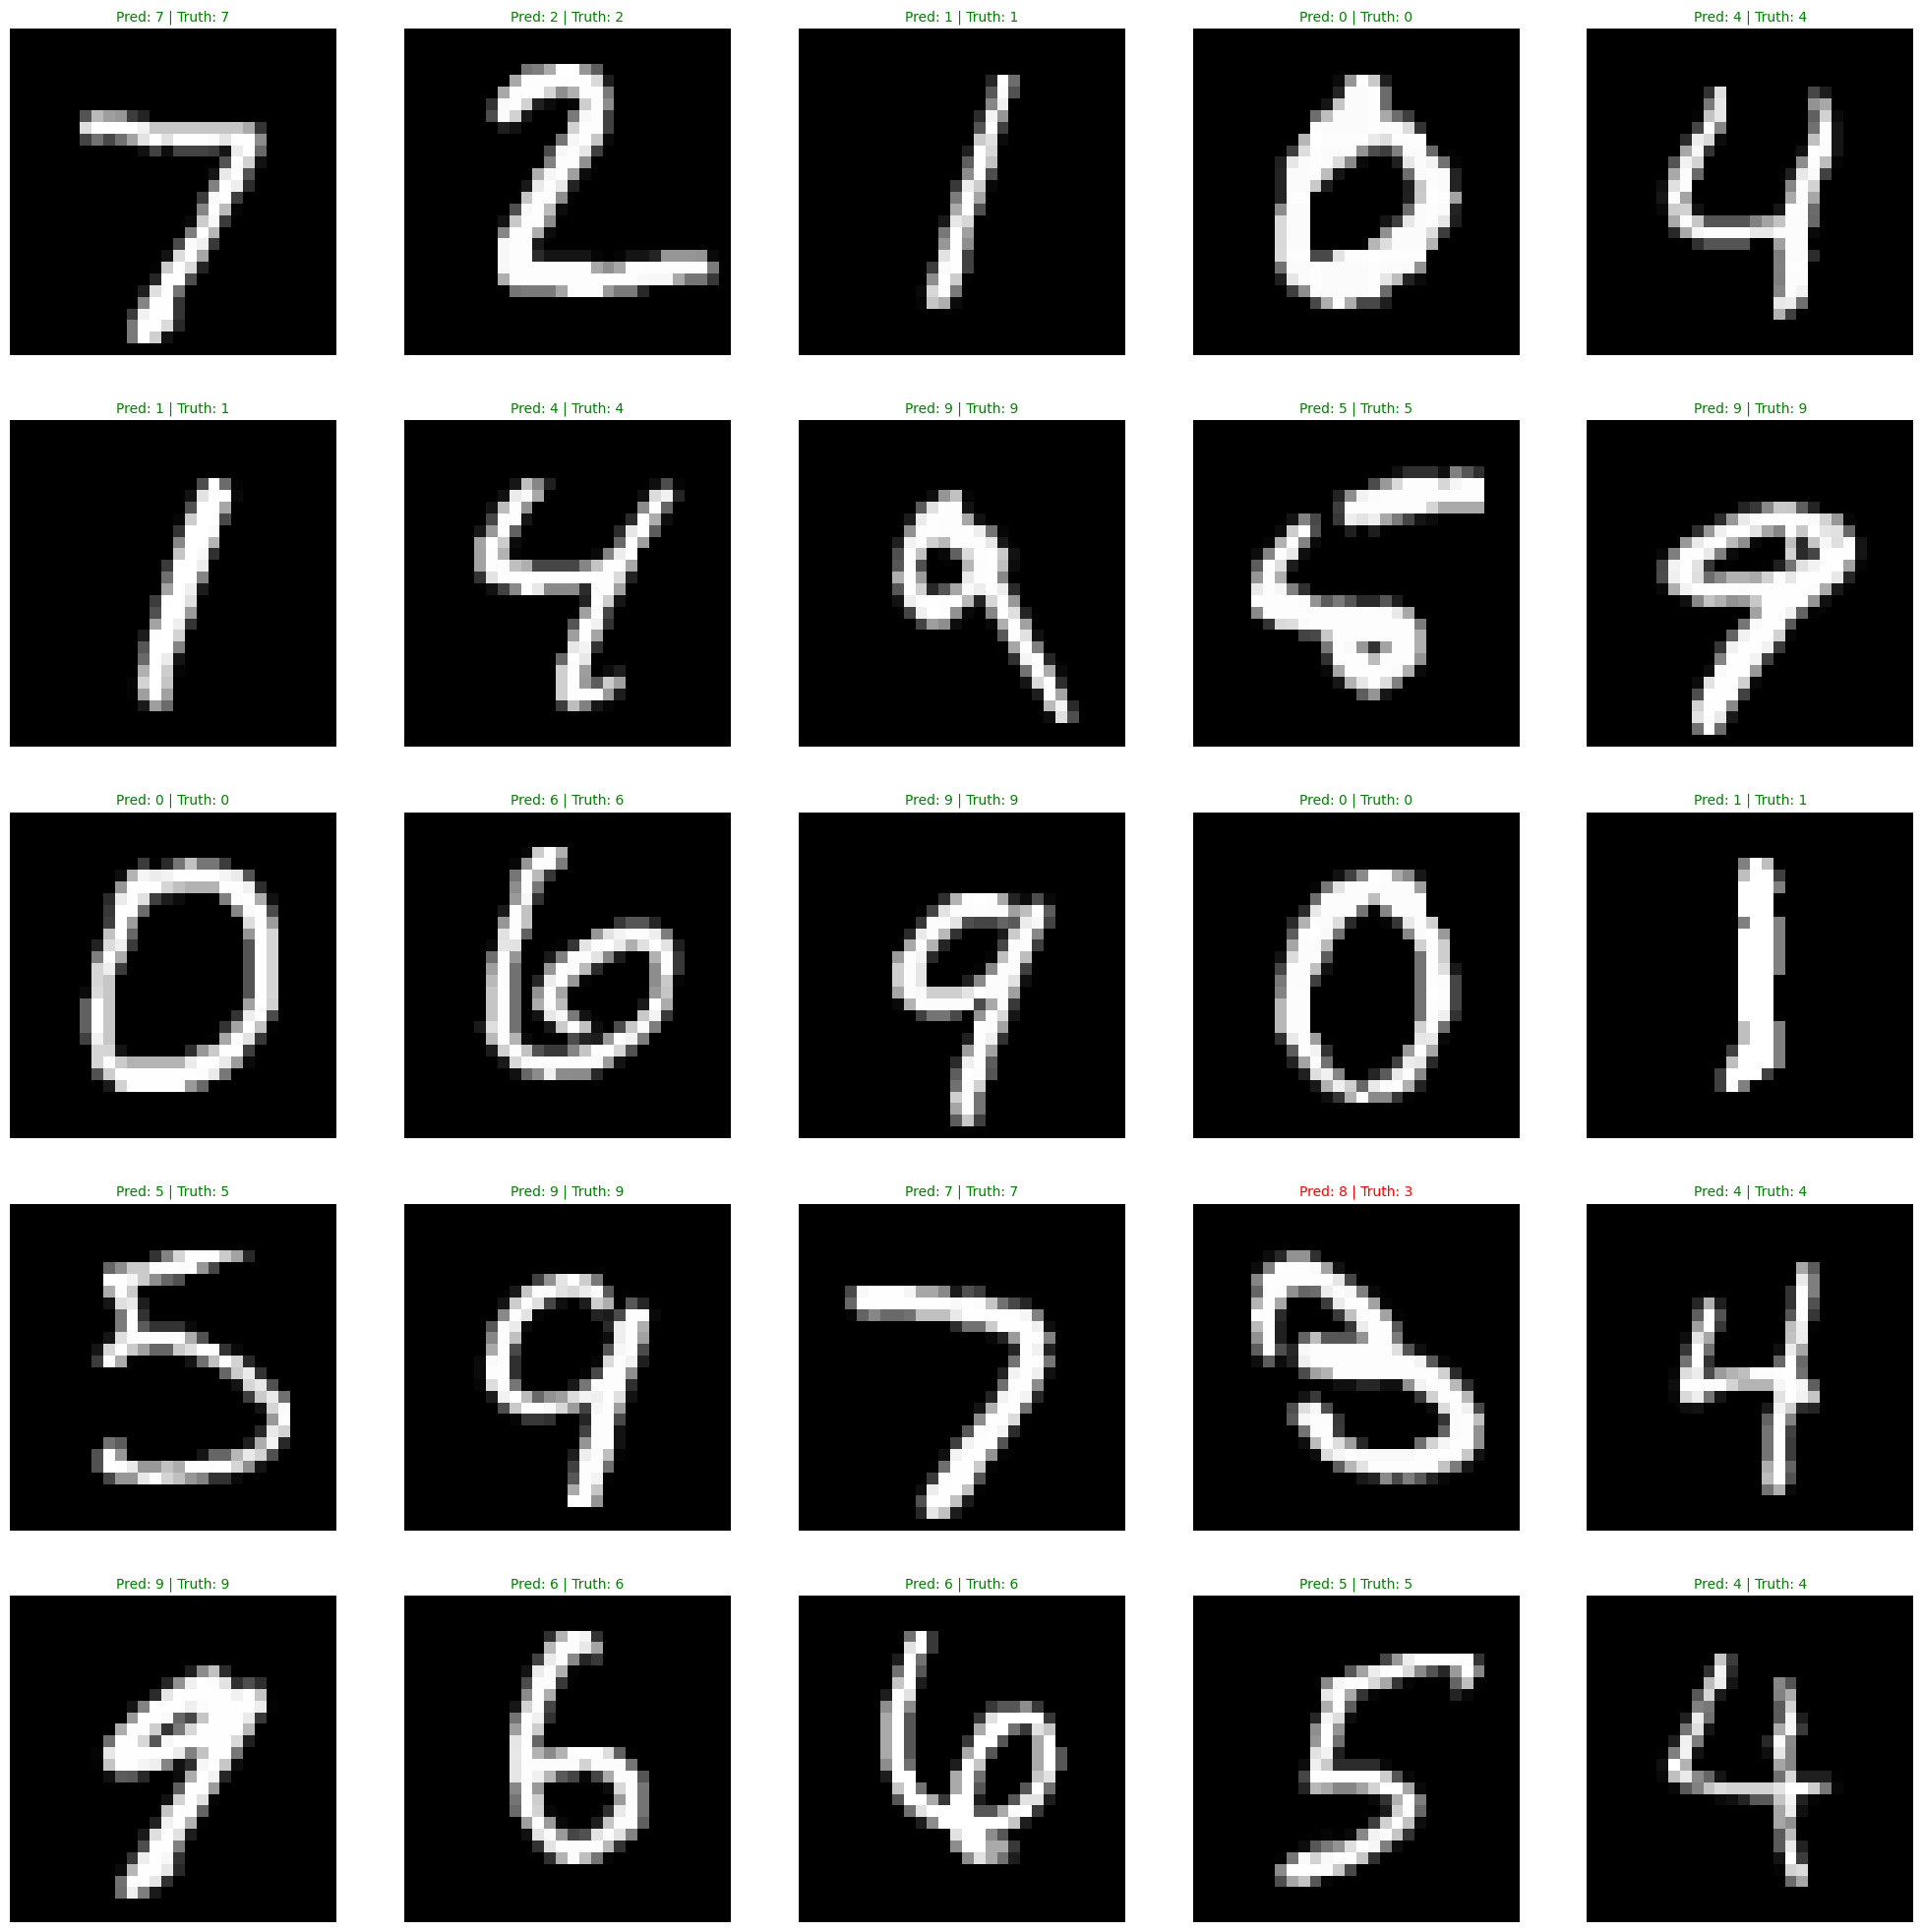

In [18]:
plt.figure(figsize=(25,25))
nrows = 5
ncols = 5
for i in range(nrows * ncols):
  image, label = test_data[i]
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(image.squeeze(), cmap='gray')

  model_1.eval()
  with torch.no_grad():
    image = image.to(device).unsqueeze(0)
    pred_label = model_1(image)
    pred_label = pred_label.argmax(dim=1).item()

  title_text = f"Pred: {pred_label} | Truth: {label}"
  color = "g" if pred_label == label else "r"
  plt.title(title_text, fontsize=10, c=color)
  plt.axis(False)
